## 1.5. Analysis of ISG expression

This notebook uses a list of previously identified interferon stimulated genes (ISGs) to analyze the global response of the dataset to the IFN-alpha stimulus. The list of ISGs (`interferon_stimulated_genes.csv`) has been compiled by the Essers lab and can be found on the GitHub page in the `data/gene_lists` folder.

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization

# import own functions
from plotting import *

### Load data

Here, we load the filtered HSPC dataset (as filtered in notebook 1.3) and the ISG gene list.

In [2]:
### load Anndata object with the HSPC dataset (all four subsets incl.)
adata_path = "../data/count_matrices/all_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

In [3]:
### L2 normalize dataset
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')

In [4]:
### scale dataset
sc.pp.scale(adata)

In [5]:
### load ISG list (400+ genes)
isg_path = "../data/gene_lists/interferon_stimulated_genes.csv"
isgs = pd.read_csv(isg_path, sep=";")
isgs = isgs["Gene"].values #move genes from dataframe to array

### Score cells for ISG expression
Here, we use the Scanpy built-in tool "score_genes" to score each gene for the average expression of the set of ISGs. For more information see: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes.html

In [6]:
### score all cells for ISG expression
sc.tl.score_genes(adata, isgs, score_name="ISG_score")

In [7]:
### get minimum and maximum found ISG score
max_value = adata.obs["ISG_score"].max()
min_value = adata.obs["ISG_score"].min()

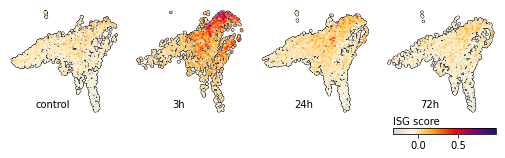

In [8]:
plot_UMAP_per_timepoint(
    adata, 
    "ISG_score", 
    min_value=min_value, 
    max_value=max_value,
    var_label="ISG score", 
    save=True, 
    time_key="time",
    save_path="../figures/1.5.ISG_score_UMAP_per_timepoint.pdf"
)

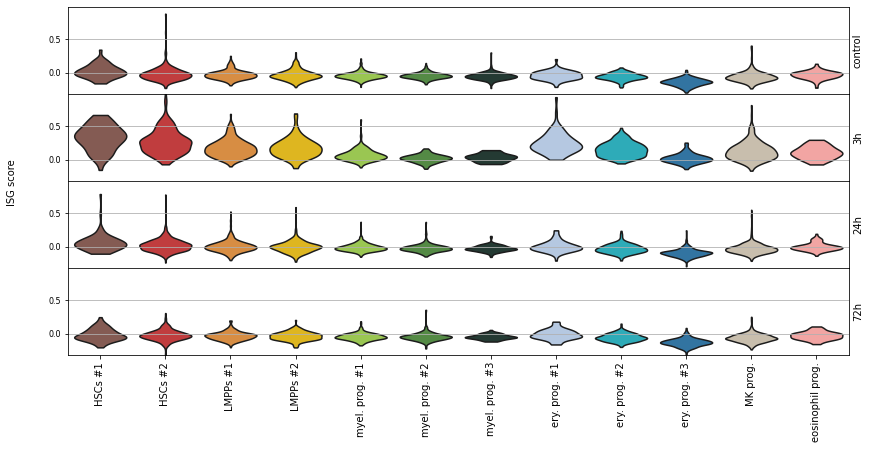

In [9]:
### plot ISG score per cluster for each cluster (violinplot)
times = adata.obs["time"].cat.categories

fig, axs = plt.subplots(len(times), 1, figsize=(14,1.6*len(times)), gridspec_kw={'wspace':0.1, 'hspace':0})

for i in range(len(times)):
    sc.pl.violin(adata[adata.obs["time"] == times[i]], "ISG_score", groupby="clusters", ax=axs[int(i)], jitter=0.4, show=False, ylabel=times[i], rotation=90, stripplot=False)

for ax in axs.flat:
    ax.get_xaxis().set_visible(False)
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.tick_params(axis='y', which='minor', labelsize=8)
    ax.set_ylim(min_value, max_value)
    ax.yaxis.set_label_position("right")
    ax.grid(axis='y')

fig.text(0.065, 0.5, 'ISG score', va='center', rotation='vertical')    
    
axs[len(times)-1].get_xaxis().set_visible(True)

# save figure
save_path = "../figures/1.5.ISG_score_violinplot_timepoints_clusters.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

plt.show()